In [1]:
from aide_design.play import*
from aide_design import floc_model as floc

#Below are the items that were imported by the code above so that you know what abbreviations to use in your code.

# Third-party imports
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib

# AIDE imports
#import aide_design
#import aide_design.pipedatabase as pipe
#from aide_design.units import unit_registry as u
#from aide_design import physchem as pc
#import aide_design.expert_inputs as exp
#import aide_design.materials_database as mat
#import aide_design.utility as ut
#import aide_design.k_value_of_reductions_utility as k
#import aide_design.pipeline_utility as pipeline
#import warnings

# DC Hydraulic Flocculation

In this design challenge you will design a vertical flow hydraulic flocculator. You will use the flow rate of `flow_plant = 20 L/s` as your default design value.

Although we don't require that you use the nomenclature from the AguaClara variable naming guide, it provides a reasonable basis for organizing your variable names. We use the convention that the first part of the variable name describes the type of variable and always has a unique dimension. The subsequent parts of the variable name start from the big picture and slowly add more and more detail to arrive at the precise component that you are describing. Thus space_floc_baffle is the spacing between baffles in the flocculator and n_floc_channel_baffle should be the number of baffles in a flocculator channel. width_floc_channel_port should be the width of the port connecting two flocculator channels.

<span style="color:blue">**In this design challenge we will use functions to calculate each step of the design. Whenever we need to access a previously calculated result we will use the function call to access that value. Using this method of nested function calls will make the entire design be only a function of a few input parameters. **</span> This makes it possible to have flexible design code and ease the creation of new plant designs.

The minimum input parameters to define a flocculator are (flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD). We could have included a longer list of input parameters (height_floc_end, width_PC_sheet, K_e, etc.) to make our functions even more general. But to keep our code more concise we will focus on only 4 of the input parameters. This will make it possible to easily change the input parameters to obtain new designs. We will use this capability to plot the results of varying the design flow rate.

## Hydraulic Vertical Flow Flocculator Design

This challenge is design a hydraulic flocculator using the core concepts of the AguaClara design methodology.

Below are the inputs for the design. BOD stands for Basis Of Design.

In [2]:
# head loss through the flocculator
headloss_floc_BOD = 40 * u.cm

# collision potential based on recent designs for AguaClara Plants
Gt_BOD = 37000

# water depth at the end of flocculator where it flows into the inlet channel of the sedimentation tank
height_floc_end = 2 * u.m

flow_plant = 20 * u.L/u.s

# This is the estimate for larger plants where the flocculator is as long as the sedimentation tanks.
# For lower flow plants we will need to reduce this length because of the constraint that the channels must
# be wide enough to construct.
length_channel_max = 6 * u.m

# minimum and maximum ratios of distance between expansions to baffle spacing
Pi_HS_min = 3
Pi_HS_max = 6

Pi_vc = pc.RATIO_VC_ORIFICE
Pi_vc_baffle = Pi_vc**2

# width of the polycarbonate sheets used to make baffles
width_PC_sheet = 1.067*u.m

# this is a reasonable constraint to keep the channel constructable by humans
width_floc_min_BOD = width_PC_sheet / 2
width_floc_max_BOD = width_PC_sheet

# expansion minor loss coefficient for 180 degree bend
K_e = (1 / Pi_vc_baffle - 1)**2

# this is the minimum temperature of the raw water
T_BOD = 15* u.degC

### Design Algorithm Steps
1. Calculate the total volume of flocculator given head loss and collision potential
2. Calculate the number of channels by taking the total width and dividing by the maximum channel width
3. Calculate the channel width (total width over number of channels)
4. Calculate the minimum number of obstacles and spacing between obstacles by assuming a maximum H/S ratio
5. Use the actual H/S ratio based on obstacle spacing to calculate the spacing between baffles
6. Calculate the obstacle width to obtain the same jet expansion conditions as produced by the 180 degree bend.

This algorithm does not yet handle the integer number of baffles in a channel or the thickness of the baffles

For this assignment **create functions for each question** and then use those function calls whenever that calculation result is required in a subsequent step. Include flow_plant, headloss_floc_BOD, Gt_BOD and T_BOD as the inputs that can be varied for each function.

__Whenever you reference a previously calculated value in a function, use the function call for that value so that dependency is not broken.__

That way you will be able to easily vary any of the three main input parameters (flow, Gt, head loss) to see their effect on the design.

### 1) 

Estimate the average velocity gradient of a flocculator given head loss and collision potential. I'm going to solve this problem for you so you see how to use function calls.

In [3]:
def G_avg(hl, Gt, T):
    G = (pc.gravity * hl) / (Gt * pc.viscosity_kinematic(T_BOD))
    return G.to(1/u.s)

print ('The average velocity gradient of flocculator is', G_avg(headloss_floc_BOD, Gt_BOD, T_BOD))

The average velocity gradient of flocculator is 93.24 / second


### 2)
Estimate the residence time of flocculator given the target head loss and collision potential. (Note that this ignores the decrease in water depth caused by head loss. We hope to improve this design process further in the near future.)

In [4]:
def t_floc_est(hl, Gt, T):
    theta = Gt / G_avg(hl, Gt, T)
    return theta.to(u.s)

print ('The residence time of flocculator is', t_floc_est(headloss_floc_BOD, Gt_BOD, T_BOD))

The residence time of flocculator is 396.8 second


### 3)
Plot $G\theta$ as a function of the operating temperature given the head loss and residence time for this design. In this step you are assuming that you have built this hydraulic flocculator and you want to see how the collision potential, $G\theta$, varies with temperature of operation.  Vary the temperature from 0°C to 30°C. The following equation makes it clear that the velocity gradient originates from head loss creates fluid deformation that is limited by viscosity.

$\bar G\theta  = \sqrt {\frac{{g{h_e}\theta }}{\nu }} $
$\theta$

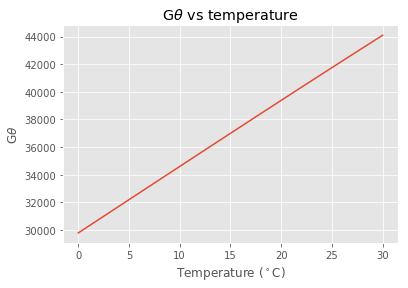

In [5]:
def Gt_operation(hl,Gt,T_BOD,T):
    Gt_operation = np.sqrt(pc.gravity * hl * t_floc_est(hl, Gt, T_BOD)/pc.viscosity_kinematic(T))
    return Gt_operation.to(u.dimensionless)
Temp_Operation=np.linspace(0, 30)*u.degC
ypoints=(Gt_operation(headloss_floc_BOD, Gt_BOD, T_BOD,Temp_Operation))

plt.plot(Temp_Operation,ypoints,'-')
#Note the use of latex. The r tells matplotlib to interpret the following strings as raw text.
#Without the "r" the \theta would be parsed as a tab (\t) followed by heta!
plt.xlabel(r'Temperature ($^\circ$C)')
plt.ylabel(r'G$\theta$')
plt.title(r'G$\theta$ vs temperature')
plt.show() 

### 4)
The following floc model equation creates the link between $\bar Gt$ and flocculator performance.

$pC^* = \frac{3}{2}\log \left( {\frac{2}{3}\pi k\frac{{d_{Clay}^2}}{{\Lambda _0^2}}\bar Gt\alpha  + 1} \right) $

What does the floc model and the graph tell you about flocculator performance and flocculator design? Explain why performance varies with temperature. 

Flocculator performance improves with warmer temperatures because the fluid deforms more given the same input energy. Flocculators should be designed to perform well based on the coldest operating temperature that they will encounter. 

### 5)
Calculate the volume of flocculator. Note that this volume does not take into account the extra volume that flocculator will have due to the changing water level caused by the head loss. Simply estimate the volume based on the residence time and the flow rate.

In [6]:
def vol_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    vol = t_floc_est(headloss_floc_BOD, Gt_BOD, T_BOD )*flow_plant
    return vol.to(u.m**3)

print('The volume of flocculator is', vol_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The volume of flocculator is 7.936 meter ** 3


### 6)
Calculate the actual length of the flocculator channels. This must meet two constraints. First, it must be less than or equal to the maximum channel length. Second, the channel length is limited by the flocculator volume, height, minimum number of channels, and minimum width of the channels. This second constraint is important for low flow rates so that the flocculator has the correct target volume. Make sure to use this floc channel length in subsequent calculations.

In [7]:
def length_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):

    #The factor of two below is because the minimum number of channels in the flocculator is two. 
    #This is a result of the orientation of the sedimentation tanks and the plumbing in the plant. 
    #Unless the design is for very low flows (<10 L/s), there will always be an even number of flocculator channels.
    length = vol_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)/width_floc_min_BOD/2/height_floc_end
    return min(length,length_channel_max)

print('The maximum channel length is',length_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The maximum channel length is 3.719 meter


### 7)
Calculate the combined total width of the flocculator channels (not including walls) based on the given length and depth.

In [8]:
def width_floc_total(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    width_floc = vol_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)/(length_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)*height_floc_end)
    return width_floc.to(u.m)

print ('The total width of the flocculator channels is is', width_floc_total(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The total width of the flocculator channels is is 1.067 meter


### 8)
Calculate the minimum channel width required to achieve H/S>3. The channel can be wider than this, but this is the absolute minimum width for a channel. The minimum width occurs when there is only one expansion per baffle and thus the distance between expansions is the same as the depth of water at the end of the flocculator.

${W_{Min}} = \frac{{\Pi _{HS}}Q}{H_e}{\left( {\frac{K_e}{2{H_e}\nu {\bar G}^2}} \right)^{\frac{1}{3}}}$

In [9]:
def width_floc_min_est(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    Gavg = G_avg(headloss_floc_BOD, Gt_BOD, T_BOD)
    nu = pc.viscosity_kinematic(T_BOD)
    width_floc_min = Pi_HS_min*((K_e/(2 * height_floc_end * (Gavg**2) * nu))**(1/3))*flow_plant/height_floc_end
    return width_floc_min.to(u.cm)

print('The minimum channel width is', width_floc_min_est(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The minimum channel width is 12.05 centimeter


### 9)
What is the minimum channel width given the additional constraint that it be constructable? Use the max function to find the true minimum channel width given both constraints.

In [10]:
def width_floc_min(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    return max(width_floc_min_est(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD),width_floc_min_BOD)

print('The minimum channel width is', width_floc_min(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The minimum channel width is 0.5335 meter


### 10)
Calculate the number of channels by taking the total flocculator width (see step 7) and dividing by the minimum channel width (round down). Include the requirement that the number of channels must be even (Use the numpy floor function - look it up!). To make this function robust, make sure that it can't ever return zero channels (the max function might be useful here)! You can convert the float to an integer with the int() function.

In [11]:
def num_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
     num = (width_floc_total(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)/
        (width_floc_min(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))).to(u.dimensionless)
# floor function with step size 2   
     num = np.floor(num/2)*2
     return int(max(num,2))

print('There are', num_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD),'channels.')


There are 2 channels.


### 11)
Calculate the actual channel width based on the number of channels the total flocculator width.

In [12]:
def width_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    width_total = width_floc_total(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)
    num_c = num_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)
    return (width_total/num_c).to(u.cm)               

print('The actual flocculator channel width is', width_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))


The actual flocculator channel width is 53.35 centimeter


### 12)
Calculate the *maximum* distance between expansions. This occurs for the largest allowable H/S ratio. Note that this isn't accounting for the integer requirement for the number of baffle spaces per channel yet.

${H_{{e_{Max}}}} = {\left[ {\frac{{{K_e}}}{{2\nu {{\bar G}^2}}}{{\left( {\frac{{Q{\Pi _{H{S_{Max}}}}}}{W}} \right)}^3}} \right]^{\frac{1}{4}}}$

In [13]:
def height_exp_max(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):

    g_avg = G_avg(headloss_floc_BOD, Gt_BOD, T_BOD)
    nu = pc.viscosity_kinematic(T_BOD)
    term1 = (K_e/(2 * (g_avg**2) * nu))**(1/4)

    term2 = (Pi_HS_max*flow_plant/width_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))**(3/4)

    height_exp = term1*term2
    return height_exp.to(u.m)

print('The maximum distance between expansions', height_exp_max(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The maximum distance between expansions 1.102 meter


### 13)
Calculate the minimum number of expansions per baffle space.

In [14]:
def num_expansions(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    return int(np.ceil(height_floc_end/(height_exp_max(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))).to(u.dimensionless))

print('The number of expansions is', num_expansions(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The number of expansions is 2


### 14)
Calculate the actual distance between expansions given the integer requirement for the number of expansions per flocculator depth.

In [15]:
def height_exp(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    
    return height_floc_end/num_expansions(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)


print('The actual distance between expansions is', height_exp(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The actual distance between expansions is 1 meter


### 15)
Calculate the spacing between baffles based on the target velocity gradient.


$ {S} = {\left( {\frac{{{K_e}}}{{2\nu {{\bar G}^2}}{H_{{e}}}}} \right)^{\frac{1}{3}}}     \frac{Q}{W}$

In [16]:
def spacing_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    
    g_avg = G_avg(headloss_floc_BOD, Gt_BOD, T_BOD)
    nu = pc.viscosity_kinematic(T_BOD)
    term1 = (K_e/(2 * height_exp(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD) * (g_avg**2) * nu))**(1/3)
    
    ans =  term1*flow_plant/width_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)
    return ans.to(u.m)

print ('The spacing between baffles is', spacing_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The spacing between baffles is 0.1898 meter


### 16)
How many baffle spaces would fit in the channel(s) given the length of the flocculator and the baffle spacing? Round to the nearest integer.

In [17]:
def num_baffles(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    num = round(num_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)*length_channel(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)/spacing_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))
    return int(num)

print ('The number of baffle spaces that would fit in the channels is', num_baffles(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The number of baffle spaces that would fit in the channels is 39


### 17)
How many baffle spaces are needed to create the required collision potential? Note that this isn't necessarily the same number as found in Problem 16. Calculating the collision potential per baffle space is the advised first step.

In [18]:
def Gt_baffle(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):

    term1 = spacing_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)*width_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)
    ans = term1*G_avg(headloss_floc_BOD, Gt_BOD, T_BOD)*height_floc_end/flow_plant
    return ans.to(u.dimensionless)

print ('The collision potential (Gt) per baffle space is', Gt_baffle(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

def num_baffle_min(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):

    ans = round(Gt_BOD/Gt_baffle(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))
    return int(ans)

print ('The minimum number of baffles required is', num_baffle_min(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The collision potential (Gt) per baffle space is 944 dimensionless
The minimum number of baffles required is 39


### 18)
Do the two estimates of the number of baffle spaces agree?

In [19]:
if num_baffles(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD) == num_baffle_min(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):
    print('Yes')
else:
    print('No')

Yes


### 19)
 Calculate the average velocity of the water in the flocculator. This is the velocity after the flow has expanded through each baffle/obstacle.

In [20]:
def vel_floc_ave(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):

    ans = flow_plant/( spacing_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD)*width_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))
    return ans.to(u.m/u.s)

print ('The average velocity of the water in the flocculator is', vel_floc_ave(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The average velocity of the water in the flocculator is 0.1975 meter / second


### 20)
Calculate the depth of water at the beginning of the flocculator based on the design head loss.

In [21]:
HEIGHT_WATER_FLOC_START = height_floc_end + headloss_floc_BOD
print ('The depth of the water at the beginning of the flocculator is', HEIGHT_WATER_FLOC_START)

The depth of the water at the beginning of the flocculator is 2.4 meter


### 21)
Estimate the residence time in the hydraulic flocculator taking head loss into account. It is okay if your estimate doesn't capture all of the details of the flocculator. You don't need to account for the volume of the baffles. Simply account for the added water due to head loss. You can approximate the extra depth as a triangle.

In [22]:
def theta_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD):

    theta_est = t_floc_est(headloss_floc_BOD, Gt_BOD, T_BOD)
    ans = theta_est*((height_floc_end + (headloss_floc_BOD/2))/height_floc_end)
    return ans.to(u.min)

print ('The residence time in the hydraulic flocculator is', theta_floc(flow_plant, headloss_floc_BOD, Gt_BOD, T_BOD))

The residence time in the hydraulic flocculator is 7.275 minute


### 22)
Create plots showing number of channels, number of expansions per water depth, total number of baffles, and channel width for a flow range from 10-100 L/s. Note that the functions that we created in this design challenge are not able to handle arrays as inputs. Use `for` loops to create the numpy arrays of y data needed for these graphs. 
Use 100 points to define each plot. Remember to initialize the numpy arrays before 

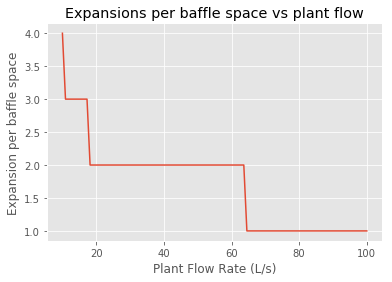

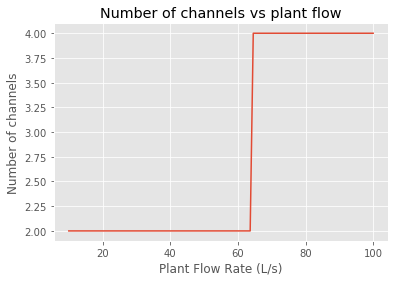

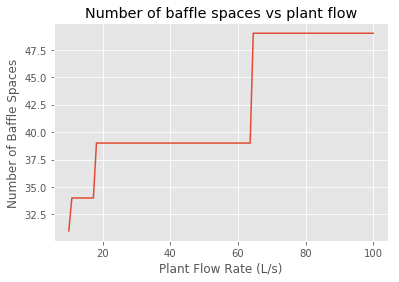

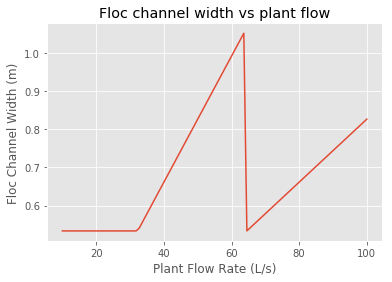

In [23]:
plot_points=100
flow_plant=np.linspace(10,100, num=plot_points, endpoint=True)*u.L/u.s

expansions=np.zeros(plot_points)
for i in range(plot_points):
    expansions[i] = num_expansions(flow_plant[i], headloss_floc_BOD, Gt_BOD, T_BOD)
plt.plot(flow_plant,expansions,'-')

plt.xlabel('Plant Flow Rate (L/s)')
plt.ylabel('Expansion per baffle space')
plt.title('Expansions per baffle space vs plant flow')
plt.show() 


channels=np.zeros(plot_points)
for i in range(plot_points):
    channels[i]=num_channel(flow_plant[i], headloss_floc_BOD, Gt_BOD, T_BOD)
plt.plot(flow_plant,channels,'-')

plt.xlabel('Plant Flow Rate (L/s)')
plt.ylabel('Number of channels')
plt.title('Number of channels vs plant flow')
plt.show() 


baffles=np.zeros(plot_points)
for i in range(plot_points):
    baffles[i]=num_baffles(flow_plant[i], headloss_floc_BOD, Gt_BOD, T_BOD)
plt.plot(flow_plant,baffles,'-')

plt.xlabel('Plant Flow Rate (L/s)')
plt.ylabel('Number of Baffle Spaces')
plt.title('Number of baffle spaces vs plant flow')
plt.show() 


width_floc_channel=np.zeros(plot_points)*u.m
for i in range(plot_points):
    width_floc_channel[i]=width_floc(flow_plant[i], headloss_floc_BOD, Gt_BOD, T_BOD)
plt.plot(flow_plant,width_floc_channel,'-')

plt.xlabel('Plant Flow Rate (L/s)')
plt.ylabel('Floc Channel Width (m)')
plt.title('Floc channel width vs plant flow')
plt.show()


### 23)
Read from the graphs to determine

1. At what flow rate is it no longer necessary to add extra obstacles in the flocculator?
1. At what flow rate does the flocculator switch from 2 channels to 4 channels?
1. **Why** did the flocculator switch from 2 to 4 channels?

1. No obstacles are needed for flows greater than about 65 L/s.
1. The flocculator switches from 2 to 4 channels at 65 L/s.
1. The channels had reached their maximum width at that flow rate.

### 24)
Change Gt_BOD to 20,000 and run the code again. Identify at least 3 changes in the design.

1. The number of channels would be 2 for all of the flows explored here.
1. The value of G increased
1. The spacing between baffles decreased
1. The flow expansions became closer together (because the spacing between baffles decreased)
1. The number of baffles decreased